In [8]:
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats import norm

## IS to compute the price of a BS Call

Upper bound
6.208784248431483
-----------------------
price with 95% confidence interval
5.917772405913603
-----------------------
Lower bound
5.626760563395724
Upper bound
6.338416121534115
-----------------------
price with 95% confidence interval
6.048328607181395
-----------------------
Lower bound
5.7582410928286745
Upper bound
6.173796498732875
-----------------------
price with 95% confidence interval
6.047876735292918
-----------------------
Lower bound
5.9219569718529605
Upper bound
6.26736537770135
-----------------------
price with 95% confidence interval
6.138624504986137
-----------------------
Lower bound
6.009883632270925
Upper bound
6.194319614224899
-----------------------
price with 95% confidence interval
6.13048721018763
-----------------------
Lower bound
6.066654806150362
Upper bound
6.08301717444704
-----------------------
price with 95% confidence interval
6.019794458017181
-----------------------
Lower bound
5.956571741587322
Upper bound
6.079491314183509
-----

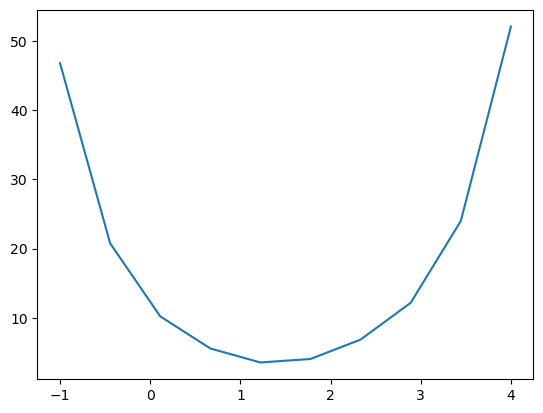

In [ ]:
def IS_MC_Call(S0,K,T,r,sigma,n_sim, mu):
    Gt = np.random.normal(0,1,n_sim)
    Wt = np.sqrt(T) * (Gt+mu)

    St = S0 * np.exp(sigma * Wt + (r-(sigma**2)/2)*T)

    payoffs = np.exp(-r*T)*np.maximum(St-K,0) * np.exp(-(mu**2)/2 -mu*Gt)

    prix = np.mean(payoffs)

    upper_bound = prix + 1.96*np.std(payoffs)/np.sqrt(n_sim)
    lower_bound = prix - 1.96*np.std(payoffs)/np.sqrt(n_sim)

    var = np.std(payoffs)

    print('Upper bound')
    print(upper_bound)
    print("-----------------------")
    print("price with 95% confidence interval")
    print(prix)
    print("-----------------------")
    print('Lower bound')
    print(lower_bound)
    
    return prix, var

prices = []
var_values = []
mu_grid = np.linspace(-1,4,10)
for val in mu_grid:
    prices += [IS_MC_Call(100,110,1,0.05,0.2,100000,val)[0]]
    var_values += [IS_MC_Call(100,110,1,0.05,0.2,100000,val)[1]]

plt.plot(mu_grid,var_values)
plt.show()

In [6]:
print(mu_grid[var_values.index(min(var_values))])

1.2222222222222223


In [7]:
IS_MC_Call(100,110,1,0.05,0.2,100000,1.2222222222222223)

Upper bound
6.047781678077266
-----------------------
price with 95% confidence interval
6.0257976339027275
-----------------------
Lower bound
6.003813589728189


(np.float64(6.0257976339027275), np.float64(3.5469210088417316))

In [9]:
def BS_option_price(S,T,K,r,sigma): 
    d1 = (np.log(S/K) + (r+0.5*(sigma**2))*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    call_price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

    return call_price

BS_price = BS_option_price(100,1,110,0.05,0.2)
print(BS_price)

6.040088129724239


## Asian Option Pricing with IS

In [17]:
import argparse
import time
import numpy as np
from math import sqrt

def e(x): 
    return np.exp(x)


def simulate_asian_mc(S0, K, r, sigma, T, mu, M=50, N=100000, option_type="call", antithetic=False, seed=None):
    """Monte-Carlo pricing for a discretely sampled arithmetic Asian option.

    Returns dict {price, std_error, ci_low, ci_high, samples}
    """

    prices = []
    var_values = []
    for val in mu :
        rng = np.random.default_rng(seed)
        dt = T / M
        discount = np.exp(-r * T)

        # Generate standard normals
        Z = rng.standard_normal(size=(N, M))
        if antithetic:
            Z_full = np.vstack([Z, -Z])
        else:
            Z_full = Z
        total_paths = Z_full.shape[0]

        drift = (r - 0.5 * sigma ** 2) * dt
        diffusion = sigma * np.sqrt(dt) * Z_full
        log_increments = drift + diffusion
        log_paths = np.cumsum(log_increments, axis=1)

        S_paths = S0 * np.exp(log_paths) * e((-val**2/2) - val*Z_full)
        arith_mean = S_paths.mean(axis=1)

        if option_type.lower() == "call":
            payoffs = np.maximum(arith_mean - K, 0.0)
        elif option_type.lower() == "put":
            payoffs = np.maximum(K - arith_mean, 0.0)
        else:
            raise ValueError("option_type must be 'call' or 'put'")

        discounted = discount * payoffs
        price_est = float(discounted.mean())
        std_error = float(discounted.std(ddof=1) / sqrt(total_paths))

        # 95% confidence interval
        z95 = 1.96
        ci_low = price_est - z95 * std_error
        ci_high = price_est + z95 * std_error

        var_values += [std_error]
        prices += [price_est]

    price_est  = prices[var_values.index(min(var_values))]
    std_error = min(var_values)
    best_mu = mu[var_values.index(min(var_values))]
    return {
        "price": price_est,
        "std_error": std_error,
        "best_mu" : best_mu,
        "samples": int(total_paths),
    }


def parse_args():
    p = argparse.ArgumentParser(description="Monte-Carlo Asian option pricer")
    p.add_argument("--S0", type=float, default=100.0, help="Spot price")
    p.add_argument("--K", type=float, default=100.0, help="Strike")
    p.add_argument("--r", type=float, default=0.05, help="Risk-free rate (annual, cont.)")
    p.add_argument("--sigma", type=float, default=0.2, help="Volatility (annual)")
    p.add_argument("--T", type=float, default=1.0, help="Time to maturity (years)")
    p.add_argument("--M", type=int, default=50, help="Number of observation dates")
    p.add_argument("--N", type=int, default=100000, help="Number of Monte-Carlo base paths")
    p.add_argument("--type", choices=["call", "put"], default="call", help="Option type")
    p.add_argument("--antithetic", action="store_true", help="Use antithetic variates")
    p.add_argument("--seed", type=int, default=None, help="RNG seed (optional)")
    return p.parse_args()


def main():
    args = parse_args()
    params = vars(args)

    print("Asian option Monte-Carlo pricer")
    print("Parameters:")
    for k, v in params.items():
        print(f"  {k} = {v}")

    t0 = time.time()
    res = simulate_asian_mc(
        S0=args.S0,
        K=args.K,
        r=args.r,
        sigma=args.sigma,
        T=args.T,
        M=args.M,
        N=args.N,
        option_type=args.type,
        antithetic=args.antithetic,
        seed=args.seed,
    )
    t1 = time.time()

    print("\nResult:")
    print(f"  Price estimate = {res['price']:.6f}")
    print(f"  Std error     = {res['std_error']:.6f}")
    print(f"  best mu value = {res["best_mu"]:.6f}")
    print(f"  Samples       = {res['samples']}")
    print(f"  Elapsed time  = {t1-t0:.3f} s")


if __name__ == "__main__":
    # ⚠ Ici pas d'argparse
    params = {
        "S0": 100.0,
        "K": 100.0,
        "r": 0.05,
        "sigma": 0.2,
        "T": 1.0,
        "M": 50,
        "N": 200000,
        "option_type": "call",
        "antithetic": False,
        "seed": 2025,
        "mu" : np.linspace(-3,2,20)
    }

    print("Asian option Monte-Carlo pricer")
    for k, v in params.items():
        print(f"  {k} = {v}")

    t0 = time.time()
    res = simulate_asian_mc(**params)
    t1 = time.time()

    print("\nResult:")
    print(f"  Price estimate = {res['price']:.6f}")
    print(f"  Std error     = {res['std_error']:.6f}")
    print(f"  best mu value = {res["best_mu"]:.6f}")
    print(f"  Samples       = {res['samples']}")
    print(f"  Elapsed time  = {t1-t0:.3f} s")

Asian option Monte-Carlo pricer
  S0 = 100.0
  K = 100.0
  r = 0.05
  sigma = 0.2
  T = 1.0
  M = 50
  N = 200000
  option_type = call
  antithetic = False
  seed = 2025
  mu = [-3.         -2.73684211 -2.47368421 -2.21052632 -1.94736842 -1.68421053
 -1.42105263 -1.15789474 -0.89473684 -0.63157895 -0.36842105 -0.10526316
  0.15789474  0.42105263  0.68421053  0.94736842  1.21052632  1.47368421
  1.73684211  2.        ]

Result:
  Price estimate = 3.206202
  Std error     = 0.011253
  best mu value = 0.684211
  Samples       = 200000
  Elapsed time  = 2.907 s


## Checking Variance reduction for the Put value ATM/OTM/ITM

In [24]:
def Put_MC(S,K,T,r,sigma,n) :
    Gt = np.random.normal(0,1,n)
    Wt = np.sqrt(T) * Gt

    St = S * np.exp(sigma * Wt + (r-(sigma**2)/2)*T)

    payoffs = np.maximum(K-St,0)

    prix = np.exp(-r*T)*np.mean(payoffs)

    upper_bound = prix + 1.96*np.std(payoffs)/np.sqrt(n)
    lower_bound = prix - 1.96*np.std(payoffs)/np.sqrt(n)

    print('Upper bound')
    print(upper_bound)
    print("-----------------------")
    print("price with 95% confidence interval")
    print(prix)
    print("-----------------------")
    print('Lower bound')
    print(lower_bound)
    print("------------------------")
    print('Std error of the simulations :', np.std(payoffs))
    
    return prix


MC_price = Put_MC(100,70,1,0.05,0.2,1000000)

Upper bound
0.12940513099651055
-----------------------
price with 95% confidence interval
0.12730316608366665
-----------------------
Lower bound
0.12520120117082276
------------------------
Std error of the simulations : 1.0724310779815782


In [28]:
MC_price = Put_MC(70,70,1,0.05,0.2,1000000)

Upper bound
3.9276440071879444
-----------------------
price with 95% confidence interval
3.9151322074812014
-----------------------
Lower bound
3.9026204077744584
------------------------
Std error of the simulations : 6.383571278950518


In [27]:
MC_price = Put_MC(60,70,1,0.05,0.2,1000000)

Upper bound
9.014027844660092
-----------------------
price with 95% confidence interval
8.996779623071035
-----------------------
Lower bound
8.979531401481978
------------------------
Std error of the simulations : 8.800113055641381


## Test IS + price of a put computation -> reducing the variance

In [31]:
def IS_MC_Put(S0,K,T,r,sigma,n_sim, mu):
    Gt = np.random.normal(0,1,n_sim)
    Wt = np.sqrt(T) * (Gt+mu)

    St = S0 * np.exp(sigma * Wt + (r-(sigma**2)/2)*T)

    payoffs = np.exp(-r*T)*np.maximum(K-St,0) * np.exp(-(mu**2)/2 -mu*Gt)

    prix = np.mean(payoffs)

    upper_bound = prix + 1.96*np.std(payoffs)/np.sqrt(n_sim)
    lower_bound = prix - 1.96*np.std(payoffs)/np.sqrt(n_sim)

    var = np.std(payoffs)
    
    return prix, var

prices = []
var_values = []
mu_grid = np.linspace(-2,3,20)
for val in mu_grid:
    prices += [IS_MC_Put(100,110,1,0.05,0.2,100000,val)[0]]
    var_values += [IS_MC_Put(100,110,1,0.05,0.2,100000,val)[1]]

best_mu = mu_grid[var_values.index(min(var_values))]
print('OTM : ',IS_MC_Put(100,70,1,0.05,0.2,100000,best_mu))
print('ATM :', IS_MC_Put(70,70,1,0.05,0.2,100000,best_mu))
print('ITM :', IS_MC_Put(60,70,1,0.05,0.2,100000,best_mu))

OTM :  (np.float64(0.12662792453637553), np.float64(0.3210991730312038))
ATM : (np.float64(3.911839525187237), np.float64(2.409601448732909))
ITM : (np.float64(9.032002986798283), np.float64(3.7533006964150615))
